**Table of contents**<a id='toc0_'></a>    
1. [Setup](#toc1_)    
2. [Get the data](#toc2_)    
3. [Explore the data](#toc3_)    
4. [Prepare the data](#toc4_)    
5. [Model](#toc5_)    
6. [Training & Evaluation](#toc6_)    
7. [Driver Code](#toc7_)    
7.1. [Standalone](#toc7_1_)    
7.2. [Hyperparameter Tuning](#toc7_2_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>[Setup](#toc0_)

reference - https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [60]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from math import sqrt
from numpy import concatenate
import datetime as dt
from pprint import pprint
from itertools import combinations
import yfinance as yf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# 2. <a id='toc2_'></a>[Get the data](#toc0_)

In [61]:
# Override pandas datareader with yfinance
yf.pdr_override()
# Define the list of stock symbols
y_symbols = ['AAPL', 'GOOG', 'AMZN', 'TSLA', 'MSFT']
# Define the start and end dates for data retrieval
startdate = dt.datetime(2015, 1, 1)
enddate = dt.datetime(2020, 12, 31)
# Retrieve historical stock price data for the specified symbols and date range
df = yf.download(y_symbols, start=startdate, end=enddate)
# Stack the multi-level index to create a single-level index
df = df.stack(level=1)
# Reset the index to make 'Date' a regular column
df = df.reset_index()
# Rename the columns to match the desired structure
df.columns = ['Date', 'Stock', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

# # Save to a csv file
# df.to_csv("Data/df_stocks.csv", index=False)

df

[*********************100%%**********************]  5 of 5 completed


,Date,Stock,Adj Close,Close,High,Low,Open,Volume
0,2015-01-02,AAPL,24.466452,27.332500,27.860001,26.837500,27.847500,212818400
1,2015-01-02,AMZN,15.426000,15.426000,15.737500,15.348000,15.629000,55664000
2,2015-01-02,GOOG,26.168653,26.168653,26.490770,26.133251,26.378078,28951268
3,2015-01-02,MSFT,40.452732,46.759998,47.419998,46.540001,46.660000,27913900
4,2015-01-02,TSLA,14.620667,14.620667,14.883333,14.217333,14.858000,71466000
...,...,...,...,...,...,...,...,...
7545,2020-12-30,AAPL,131.399368,133.720001,135.990005,133.399994,135.580002,96452100
7546,2020-12-30,AMZN,164.292496,164.292496,167.104996,164.123505,167.050003,64186000
7547,2020-12-30,GOOG,86.975998,86.975998,88.254753,86.279999,88.100502,26122000
7548,2020-12-30,MSFT,215.882248,221.679993,225.630005,221.470001,225.229996,20272300


# 3. <a id='toc3_'></a>[Explore the data](#toc0_)

In [62]:
# # Load the data
# df = pd.read_csv("Data/df_stocks.csv")

In [63]:
# Check for missing values
df.isnull().sum()

Date         0
Stock        0
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64

In [64]:
# Get counts for each stock
df["Stock"].value_counts()

Stock
AAPL    1510
AMZN    1510
GOOG    1510
MSFT    1510
TSLA    1510
Name: count, dtype: int64

In [65]:
# Calculate the difference in days
(enddate - startdate).days

2191

For  TSLA  :


<Figure size 640x480 with 0 Axes>

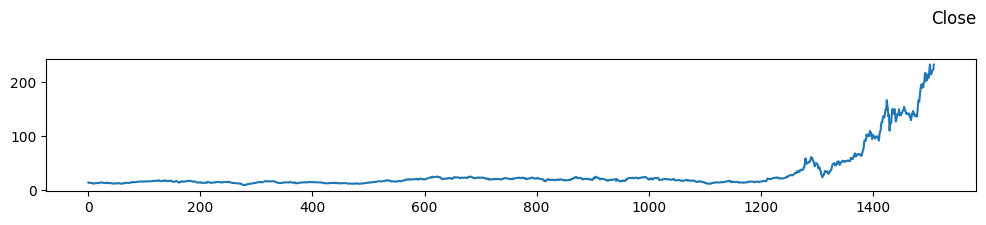

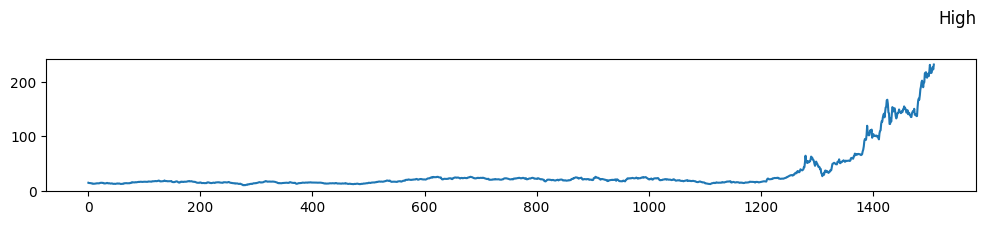

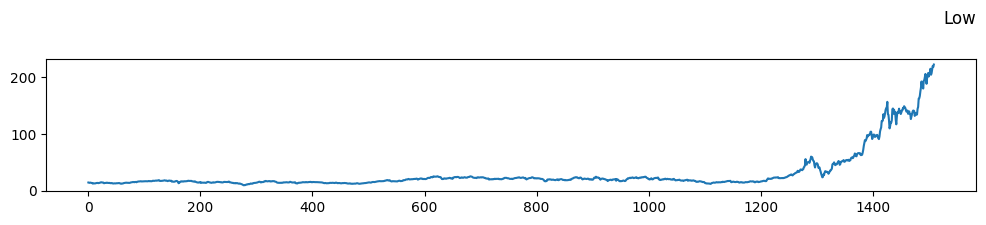

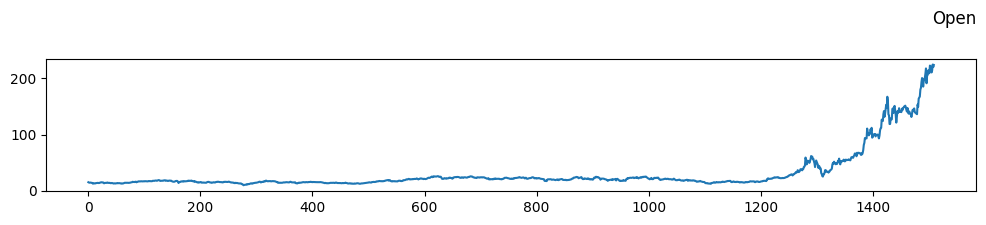

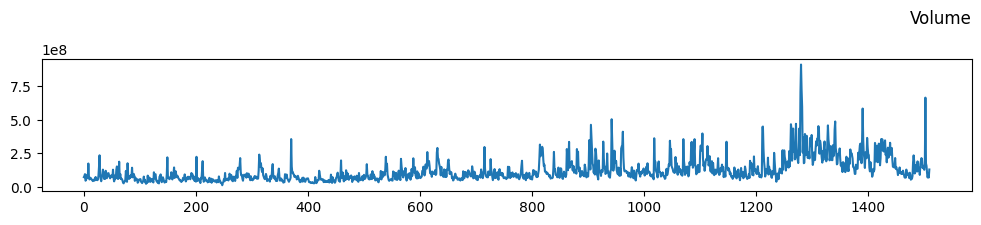

In [66]:
def stock_features_distibution(df, selected_stock):
    # Select the stock
    df = df[df["Stock"]==selected_stock]
    df.index = df["Date"]
    df = df.drop(columns=["Date","Stock"])
    values = df.values

    # specify columns to plot
    groups = [1, 2, 3, 4, 5]
    i = 1

    # plot each column
    print("For ", selected_stock, " :")
    plt.figure()
    for group in groups:
        plt.figure(figsize=(12, 10))
        plt.subplot(len(groups), 1, i)
        plt.plot(values[:, group])
        plt.title(df.columns[group], y=1.2, loc='right')
        i += 1
    plt.show()
    
stock_features_distibution(df, "TSLA")

# 4. <a id='toc4_'></a>[Prepare the data](#toc0_)

In [67]:
# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.squeeze(y_true), np.squeeze(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [123]:
# Prepare the data
def prepare_data_uni(df, choosen_stock, look_back):
    # Choose specific stock
    data = df[df["Stock"]==choosen_stock ]
    
    # Filter data for years 2015-2018 for training
    train_data = data[data["Date"].dt.year.isin(range(2015, 2019))]
    valid_size = int(len(data) * 0.10)
    train_data, valid_data = train_data[:-valid_size], train_data[-valid_size:]

    # Filter data for the year 2019 for testing
    test_data = data[data["Date"].dt.year == 2019]
    # test_data = data[(data["Date"].dt.year == 2019) & (data["Date"].dt.month.isin([1]))]
    # test_data = data[(data["Date"] >= "2019-01-01") & (data["Date"] <= "2019-01-10")]
    
    # Feature selection and engineering: Consider only the 'Close' column
    train_data = train_data[["Date", "Close"]]
    valid_data = valid_data[["Date", "Close"]]
    test_data = test_data[["Date", "Close"]]

    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_data["Close"] = scaler.fit_transform(train_data[["Close"]])
    valid_data["Close"] = scaler.transform(valid_data[["Close"]])
    test_data["Close"] = scaler.transform(test_data[["Close"]])
    
    def create_sequences(dataset, look_back=1):
        X, Y, dates = [], [], []
        for i in range(len(dataset) - look_back):
            X.append(dataset[i:(i + look_back), 1:2])  # Assuming the 'Close' column is at index 2
            Y.append(dataset[i + look_back, 1])  # Assuming the 'Close' column is at index 2
            dates.append(dataset[i + look_back, 0])
        return np.array(X), np.array(Y), np.array(dates)

    train_X, train_Y, train_dates = create_sequences(train_data.values, look_back)
    valid_X, valid_Y, valid_dates = create_sequences(valid_data.values, look_back)
    test_X, test_Y, test_dates = create_sequences(test_data.values, look_back)

    # Convert data to PyTorch tensors
    train_X = torch.from_numpy(train_X.astype(np.float32)).view(-1, 1, look_back)
    train_Y = torch.Tensor(train_Y).view(-1, 1)
    valid_X = torch.Tensor(valid_X.astype(np.float32)).view(-1, 1, look_back)
    valid_Y = torch.Tensor(valid_Y).view(-1, 1)
    test_X = torch.Tensor(test_X.astype(np.float32)).view(-1, 1, look_back)
    test_Y = torch.Tensor(test_Y).view(-1, 1)

    return train_X, train_Y, train_dates, valid_X, valid_Y, valid_dates, test_X, test_Y, test_dates, scaler

# 5. <a id='toc5_'></a>[Model](#toc0_)

In [120]:
# Define the LSTM model with different hidden sizes
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_sizes = hidden_sizes
        self.num_layers = num_layers
        self.lstm_layers = nn.ModuleList([
            nn.LSTM(input_size, hidden_sizes[i], num_layers, batch_first=True) if i == 0 else nn.LSTM(hidden_sizes[i - 1], hidden_sizes[i], num_layers, batch_first=True) for i in range(len(hidden_sizes))
        ])
        self.fc = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x):
        h0 = [torch.zeros(self.num_layers, x.size(0), size) for size in self.hidden_sizes]
        c0 = [torch.zeros(self.num_layers, x.size(0), size) for size in self.hidden_sizes]
        out = x
        for i in range(len(self.hidden_sizes)):
            out, _ = self.lstm_layers[i](out, (h0[i], c0[i]))
        out = self.fc(out[:, -1, :])
        return out

# 6. <a id='toc6_'></a>[Training & Evaluation](#toc0_)

In [125]:
def train_evaluate_lstm_uni(input_size, hidden_size, num_layers, output_size, learning_rate, num_epochs, train_X, train_Y, valid_X, valid_Y, test_X, test_Y, scaler, visualize=False):
    # Initialize the model
    model = LSTMModel(input_size, hidden_size, num_layers, output_size)

    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
    # Training the model
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        outputs = model(train_X)
        optimizer.zero_grad()
        loss = criterion(outputs, train_Y)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        model.eval()
        val_outputs = model(valid_X)
        val_loss = criterion(val_outputs, valid_Y)
        val_losses.append(val_loss.item())
        
        if visualize == True:
            if (epoch + 1) % 20 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')
    
    # Evaluate the model on the test set
    test_outputs = model(test_X)

    # Inverse transform the predictions to the original scale
    train_predict = scaler.inverse_transform(outputs.detach().numpy())
    train_Y = scaler.inverse_transform(train_Y.numpy())
    valid_predict = scaler.inverse_transform(val_outputs.detach().numpy())
    valid_Y = scaler.inverse_transform(valid_Y.numpy())
    test_predict = scaler.inverse_transform(test_outputs.detach().numpy())
    test_Y = scaler.inverse_transform(test_Y.numpy())

    # Compute MAPE
    train_mape = mean_absolute_percentage_error(train_Y, train_predict)
    valid_mape = mean_absolute_percentage_error(valid_Y, valid_predict)
    test_mape = mean_absolute_percentage_error(test_Y, test_predict)

    # Evaluate the model using metrics like mean squared error (MSE)
    train_rmse = mean_squared_error(train_Y, train_predict, squared=False)
    valid_rmse = mean_squared_error(valid_Y, valid_predict, squared=False)
    test_rmse = mean_squared_error(test_Y, test_predict, squared=False)

    if visualize:
        # 1. Visualize training and validation loss
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Training Loss', linewidth=2)
        plt.plot(val_losses, label='Validation Loss', linewidth=2)
        plt.title("Training and Validation Loss Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.show()

        # 2. Visualize test and predictions
        plt.figure(figsize=(10, 5))
        plt.plot(test_dates, test_Y, label='True', linewidth=2)
        plt.plot(test_dates, test_predict, label='Predicted', linewidth=2)
        plt.title("Test vs. Predicted Prices")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()

    return model, loss, train_rmse, valid_rmse, test_rmse, train_mape, valid_mape, test_mape

# 7. <a id='toc7_'></a>[Driver Code](#toc0_)

## 7.1. <a id='toc7_1_'></a>[Standalone](#toc0_)

Epoch [20/100], Training Loss: 0.0103, Validation Loss: 0.0085
Epoch [40/100], Training Loss: 0.0019, Validation Loss: 0.0017
Epoch [60/100], Training Loss: 0.0010, Validation Loss: 0.0021
Epoch [80/100], Training Loss: 0.0008, Validation Loss: 0.0016
Epoch [100/100], Training Loss: 0.0007, Validation Loss: 0.0015


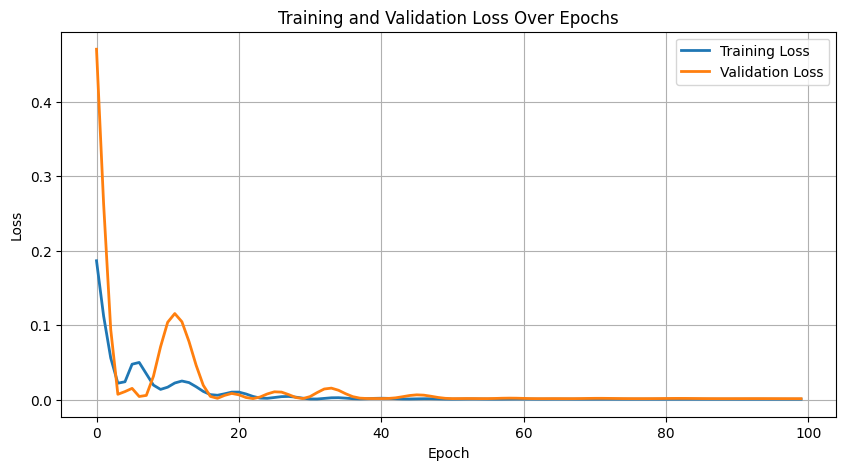

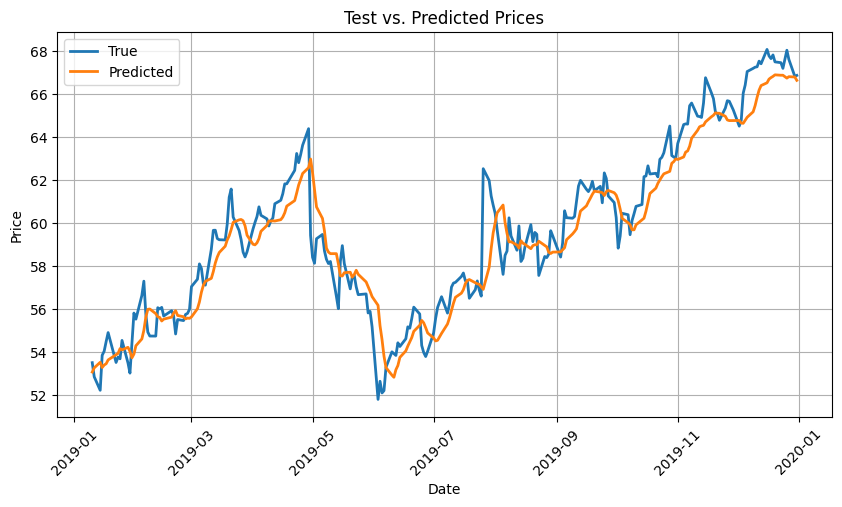

LSTMModel(
  (lstm_layers): ModuleList(
    (0): LSTM(6, 128, batch_first=True)
  )
  (fc): Linear(in_features=128, out_features=1, bias=True)
)
0.9263916 1.3151044 1.2421769
1.7089810222387314 1.8675092607736588 1.6294211149215698


In [127]:
## Standalone code

# Load the data
# df = pd.read_csv("Data/df_stocks.csv")
df['Date'] = pd.to_datetime(df['Date'])

# Hyperparameters
choosen_stock = "GOOG" # [TSLA, GOOG, AAPL, MSFT, AMZN]
look_back = 6  # Adjust the look_back window as needed
input_size = look_back
hidden_size = [128]
num_layers = 1
output_size = 1
learning_rate = 0.01
num_epochs = 100
years_to_include = [2015, 2016, 2017, 2018, 2019]

# Prepare the data
train_X, train_Y, train_dates, valid_X, valid_Y, valid_dates, test_X, test_Y, test_dates, scaler = prepare_data_uni(df, choosen_stock, look_back)

# Train the model
model, loss, train_rmse, valid_rmse, test_rmse, train_mape, valid_mape, test_mape = train_evaluate_lstm_uni(input_size, hidden_size, num_layers, output_size, learning_rate, num_epochs, train_X, train_Y, valid_X, valid_Y, test_X, test_Y, scaler, visualize=True)

print(model)
print(train_rmse, valid_rmse, test_rmse)
print(train_mape, valid_mape, test_mape)

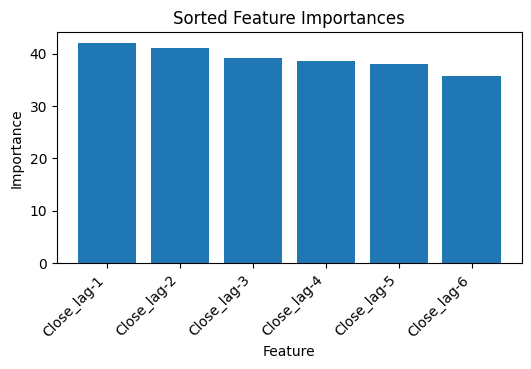

In [41]:
# Feature Importances (approximation using first layer weights)
first_layer_weights = model.lstm_layers[0].weight_ih_l0.detach().numpy()
feature_names = [f"{df.columns[3]}_lag-{i}" for i in range(look_back, 0, -1)]  # Assuming 'Close' is in the third column

feature_importances = np.sum(np.abs(first_layer_weights), axis=0)  # L1 norm

# Sort feature importances and corresponding feature names
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# Visualize sorted feature importances
plt.figure(figsize=(6, 3))
plt.bar(range(len(sorted_feature_importances)), sorted_feature_importances, tick_label=sorted_feature_names)
plt.title("Sorted Feature Importances")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.show()

## 7.2. <a id='toc7_2_'></a>[Hyperparameter Tuning](#toc0_)

In [26]:
## Tuning

# Load the data
# df = pd.read_csv("Data/df_stocks.csv")
df['Date'] = pd.to_datetime(df['Date'])

# Hyperparameters
choosen_stock = "GOOG"  # [TSLA, GOOG, AAPL, MSFT, AMZN]
look_back_values = [5, 10, 30]  # Adjust the look_back window values as needed

options = [64, 128] # Adjust the hidden_size values as needed
combinations_list = []
for r in range(1, 4):  # To get combinations of 1, 2, and 3 items
    combinations_list.extend(combinations(options * r, r))
combinations_list = [list(comb) for comb in combinations_list]
hidden_size_values = combinations_list

num_layers_values = [1] # [2, 3, 4]  # Adjust the num_layers values as needed
learning_rate_values = [0.005, 0.01, 0.02]  # Adjust the learning_rate values as needed
num_epochs = 100
years_to_include = [2015, 2016, 2017, 2018, 2019]

best_models = []
top_k = 3  # Get the top k performing models

# Hyperparameter tuning loop
for look_back in look_back_values:
    for hidden_size in hidden_size_values:
        for num_layers in num_layers_values:
            for learning_rate in learning_rate_values:
                # print(f"\nHyperparameters: look_back={look_back}, hidden_size={hidden_size}, num_layers={num_layers}, learning_rate={learning_rate}")
                train_X, train_Y, valid_X, valid_Y, test_X, test_Y, scaler = prepare_data_uni(df, choosen_stock, look_back)
                model, loss, train_rmse, valid_rmse, test_rmse, train_mape, valid_mape, test_mape = train_evaluate_lstm_uni(look_back, hidden_size, num_layers, 1, learning_rate, num_epochs, train_X, train_Y, valid_X, valid_Y, test_X, test_Y, scaler)
                best_models.append({
                    "look_back": look_back,
                    "model" : model,
                    "learning_rate": learning_rate,
                    # "train_rmse": train_rmse,
                    # "valid_rmse": valid_rmse,
                    "test_rmse": test_rmse,
                    # "train_mape": train_mape,
                    # "valid_mape": valid_mape,
                    "test_mape": test_mape,
                })

# Sort the models by RMSE in ascending order
best_models.sort(key=lambda x: (x["test_rmse"], x["test_mape"]))

# Print the top-k performing models
print(f"\nTop {top_k} Performing Models:")
pprint(best_models[:top_k])


Top 3 Performing Models:
[{'learning_rate': 0.01,
  'look_back': 5,
  'model': LSTMModel(
  (lstm_layers): ModuleList(
    (0): LSTM(5, 128, batch_first=True)
  )
  (fc): Linear(in_features=128, out_features=1, bias=True)
),
  'test_mape': 1.4563674107193947,
  'test_rmse': 1.1676246},
 {'learning_rate': 0.01,
  'look_back': 5,
  'model': LSTMModel(
  (lstm_layers): ModuleList(
    (0): LSTM(5, 64, batch_first=True)
  )
  (fc): Linear(in_features=64, out_features=1, bias=True)
),
  'test_mape': 1.5442446805536747,
  'test_rmse': 1.19658},
 {'learning_rate': 0.005,
  'look_back': 5,
  'model': LSTMModel(
  (lstm_layers): ModuleList(
    (0): LSTM(5, 64, batch_first=True)
    (1): LSTM(64, 128, batch_first=True)
  )
  (fc): Linear(in_features=128, out_features=1, bias=True)
),
  'test_mape': 1.537765096873045,
  'test_rmse': 1.2031184}]
